In [4]:
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge # Ridge = L2
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import *

tf.keras.backend.set_floatx('float64')
from assignment_utils import *

tf.autograph.set_verbosity(0)

In [5]:
# generate data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

# split the data using sklearn routine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


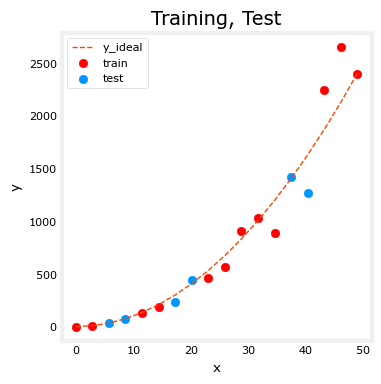

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [10]:
def eval_mse(y, yhat): # err: J_train, J_test, etc.
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    v = yhat - y # v is a vector

    return np.dot(v, v) / (2 * m) # yup! MSE is the squared magnitude of a vector!

In [11]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


In [12]:
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

In [13]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


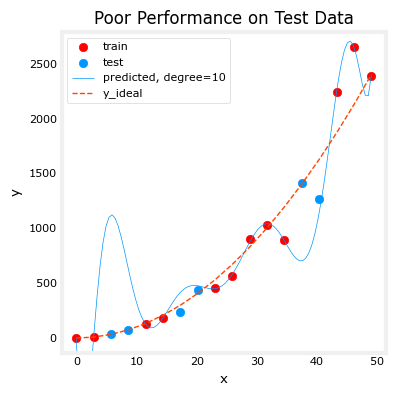

In [14]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

- High variance, overfitting, generalizes poorly

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent new data. You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

In [15]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv)

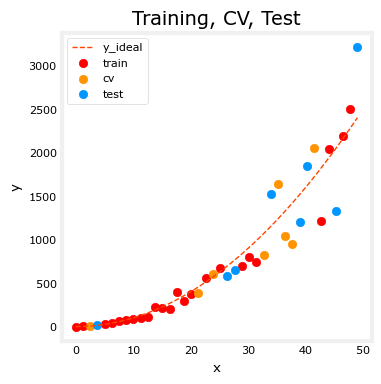

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

In [17]:
# MODEL SELECTION: SOLVE OVERFITTING VIA FEATURE SELECTION AND CHOOSE THE MODEL THAT GENERALIZES THE BEST ON THE DEV SET 

max_degree = 9
err_train = np.zeros(max_degree)
err_cv = np.zeros(max_degree)
x = np.linspace(0, int(X.max()), 100) # data gen
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    
    yhat_train = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat_train)
    
    yhat_cv = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat_cv)
    
    y_pred[:, degree] = lmodel.predict(x)

optimal_degree = np.argmin(err_cv) + 1

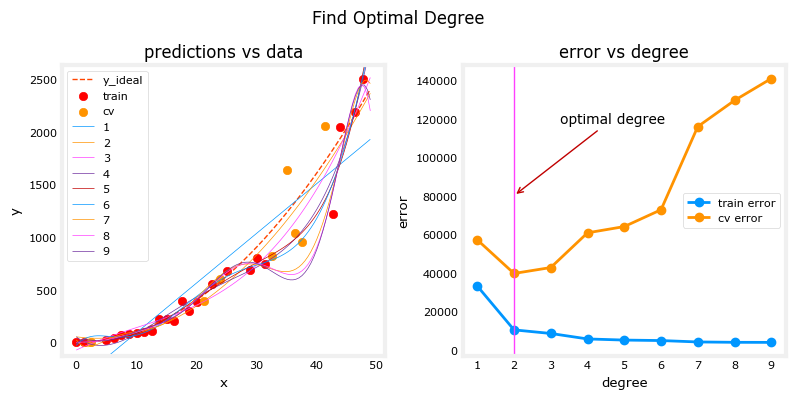

In [18]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used.

    On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point.

    on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to generalize).
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

In [19]:
# MODEL SELECTION: SOLVE OVERFITTING BY USING REGULARIZATION AND SELECT THE MODEL WITH THE REGULARIZATION THAT MINIMIZES err_cv
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10

err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_ = lambda_range[i]
    linmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    linmodel.fit(X_train, y_train)
    
    yhat_train = linmodel.predict(X_train)
    err_train[i] = linmodel.mse(y_train, yhat_train)
    
    yhat_cv = linmodel.predict(X_cv)
    err_cv[i] = linmodel.mse(y_cv, yhat_cv)
    
    y_pred[:, i] = linmodel.predict(x)

optimal_reg_idx = np.argmin(err_cv)

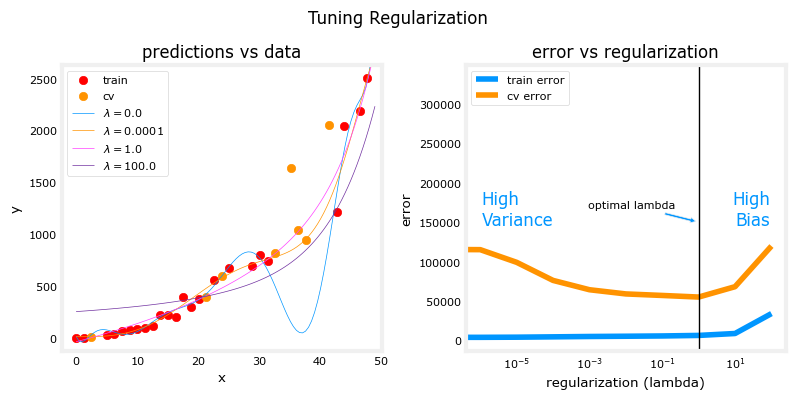

In [20]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

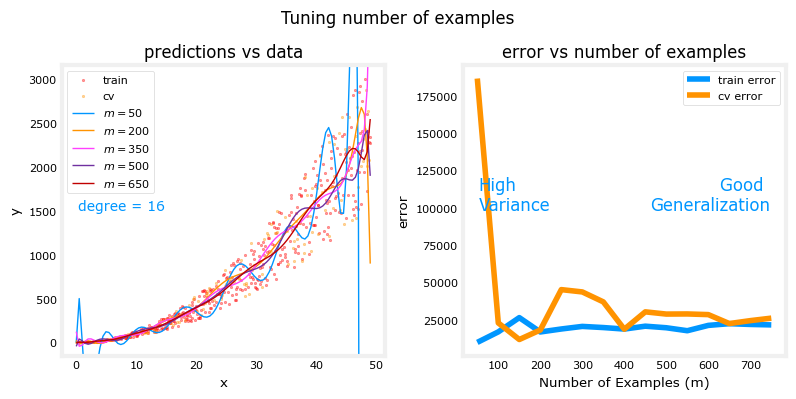

In [21]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of  is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization.

Note that adding more examples when the model has high bias (underfitting) does not improve performance.

In [23]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs() 

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


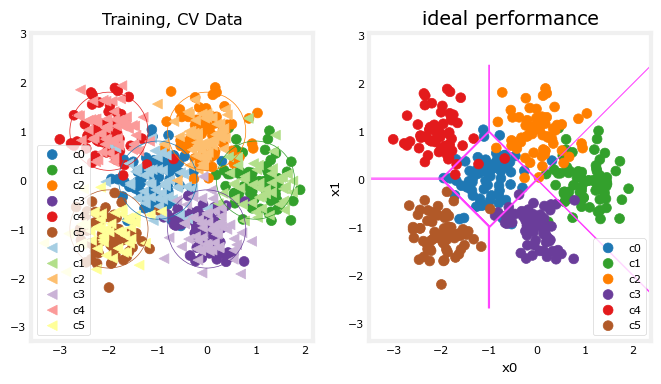

In [24]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

In [27]:
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    
    m = len(y)
    cerr = 0
    
    for i in range(m):
        if (yhat[i] != y[i]):
            cerr += 1
    
    cerr /= m
    
    return cerr

In [28]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


In [32]:
model = Sequential([
    Dense(units=120, activation='relu'),
    Dense(units=40, activation='relu'),
    Dense(units=6, activation='linear')
])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.01))

In [33]:
model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
13/13 [==============================] - 0s 667us/step - loss: 1.1302
Epoch 2/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3880
Epoch 3/1000
13/13 [==============================] - 0s 644us/step - loss: 0.2885
Epoch 4/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2540
Epoch 5/1000
13/13 [==============================] - 0s 677us/step - loss: 0.2336
Epoch 6/1000
13/13 [==============================] - 0s 704us/step - loss: 0.2491
Epoch 7/1000
13/13 [==============================] - 0s 718us/step - loss: 0.2100
Epoch 8/1000
13/13 [==============================] - 0s 621us/step - loss: 0.2333
Epoch 9/1000
13/13 [==============================] - 0s 715us/step - loss: 0.2290
Epoch 10/1000
13/13 [==============================] - 0s 675us/step - loss: 0.2553
Epoch 11/1000
13/13 [==============================] - 0s 713us/step - loss: 0.2592
Epoch 12/1000
13/13 [==============================] - 0s 695us/step - loss: 0.2309
E

13/13 [==============================] - 0s 657us/step - loss: 0.1622
Epoch 99/1000
13/13 [==============================] - 0s 725us/step - loss: 0.1677
Epoch 100/1000
13/13 [==============================] - 0s 672us/step - loss: 0.1692
Epoch 101/1000
13/13 [==============================] - 0s 675us/step - loss: 0.1728
Epoch 102/1000
13/13 [==============================] - 0s 620us/step - loss: 0.1609
Epoch 103/1000
13/13 [==============================] - 0s 728us/step - loss: 0.1457
Epoch 104/1000
13/13 [==============================] - 0s 666us/step - loss: 0.1597
Epoch 105/1000
13/13 [==============================] - 0s 624us/step - loss: 0.1563
Epoch 106/1000
13/13 [==============================] - 0s 663us/step - loss: 0.1616
Epoch 107/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1727
Epoch 108/1000
13/13 [==============================] - 0s 674us/step - loss: 0.1508
Epoch 109/1000
13/13 [==============================] - 0s 613us/step - loss: 0.1

13/13 [==============================] - 0s 667us/step - loss: 0.1111
Epoch 195/1000
13/13 [==============================] - 0s 585us/step - loss: 0.1035
Epoch 196/1000
13/13 [==============================] - 0s 650us/step - loss: 0.0992
Epoch 197/1000
13/13 [==============================] - 0s 674us/step - loss: 0.1112
Epoch 198/1000
13/13 [==============================] - 0s 688us/step - loss: 0.1037
Epoch 199/1000
13/13 [==============================] - 0s 704us/step - loss: 0.0989
Epoch 200/1000
13/13 [==============================] - 0s 668us/step - loss: 0.0973
Epoch 201/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1004
Epoch 202/1000
13/13 [==============================] - 0s 669us/step - loss: 0.1088
Epoch 203/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1134
Epoch 204/1000
13/13 [==============================] - 0s 625us/step - loss: 0.1061
Epoch 205/1000
13/13 [==============================] - 0s 699us/step - loss: 0.

13/13 [==============================] - 0s 669us/step - loss: 0.0744
Epoch 291/1000
13/13 [==============================] - 0s 668us/step - loss: 0.0785
Epoch 292/1000
13/13 [==============================] - 0s 705us/step - loss: 0.0811
Epoch 293/1000
13/13 [==============================] - 0s 810us/step - loss: 0.0810
Epoch 294/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0872
Epoch 295/1000
13/13 [==============================] - 0s 655us/step - loss: 0.1169
Epoch 296/1000
13/13 [==============================] - 0s 652us/step - loss: 0.0865
Epoch 297/1000
13/13 [==============================] - 0s 606us/step - loss: 0.0770
Epoch 298/1000
13/13 [==============================] - 0s 656us/step - loss: 0.0844
Epoch 299/1000
13/13 [==============================] - 0s 746us/step - loss: 0.0669
Epoch 300/1000
13/13 [==============================] - 0s 669us/step - loss: 0.0831
Epoch 301/1000
13/13 [==============================] - 0s 685us/step - loss: 0.

13/13 [==============================] - 0s 633us/step - loss: 0.0501
Epoch 387/1000
13/13 [==============================] - 0s 663us/step - loss: 0.0665
Epoch 388/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0683
Epoch 389/1000
13/13 [==============================] - 0s 616us/step - loss: 0.0605
Epoch 390/1000
13/13 [==============================] - 0s 682us/step - loss: 0.0587
Epoch 391/1000
13/13 [==============================] - 0s 646us/step - loss: 0.0784
Epoch 392/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0767
Epoch 393/1000
13/13 [==============================] - 0s 595us/step - loss: 0.0837
Epoch 394/1000
13/13 [==============================] - 0s 610us/step - loss: 0.0814
Epoch 395/1000
13/13 [==============================] - 0s 641us/step - loss: 0.0662
Epoch 396/1000
13/13 [==============================] - 0s 683us/step - loss: 0.0566
Epoch 397/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 727us/step - loss: 0.0367
Epoch 483/1000
13/13 [==============================] - 0s 717us/step - loss: 0.0370
Epoch 484/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0456
Epoch 485/1000
13/13 [==============================] - 0s 720us/step - loss: 0.0493
Epoch 486/1000
13/13 [==============================] - 0s 769us/step - loss: 0.0550
Epoch 487/1000
13/13 [==============================] - 0s 797us/step - loss: 0.0436
Epoch 488/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0415
Epoch 489/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0431
Epoch 490/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0413
Epoch 491/1000
13/13 [==============================] - 0s 687us/step - loss: 0.0395
Epoch 492/1000
13/13 [==============================] - 0s 693us/step - loss: 0.0447
Epoch 493/1000
13/13 [==============================] - 0s 669us/step - loss: 0.

13/13 [==============================] - 0s 673us/step - loss: 0.0232
Epoch 579/1000
13/13 [==============================] - 0s 718us/step - loss: 0.0231
Epoch 580/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0213
Epoch 581/1000
13/13 [==============================] - 0s 644us/step - loss: 0.0195
Epoch 582/1000
13/13 [==============================] - 0s 716us/step - loss: 0.0252
Epoch 583/1000
13/13 [==============================] - 0s 738us/step - loss: 0.0210
Epoch 584/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0196
Epoch 585/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0193
Epoch 586/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0219
Epoch 587/1000
13/13 [==============================] - 0s 767us/step - loss: 0.0230
Epoch 588/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0211
Epoch 589/1000
13/13 [==============================] - 0s 660us/step - loss: 0.

13/13 [==============================] - 0s 705us/step - loss: 0.0292
Epoch 675/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0305
Epoch 676/1000
13/13 [==============================] - 0s 833us/step - loss: 0.0294
Epoch 677/1000
13/13 [==============================] - 0s 772us/step - loss: 0.0326
Epoch 678/1000
13/13 [==============================] - 0s 742us/step - loss: 0.0350
Epoch 679/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0346
Epoch 680/1000
13/13 [==============================] - 0s 757us/step - loss: 0.0419
Epoch 681/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0413
Epoch 682/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0413
Epoch 683/1000
13/13 [==============================] - 0s 716us/step - loss: 0.0595
Epoch 684/1000
13/13 [==============================] - 0s 712us/step - loss: 0.0899
Epoch 685/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 633us/step - loss: 0.0372
Epoch 771/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1231
Epoch 772/1000
13/13 [==============================] - 0s 705us/step - loss: 0.0697
Epoch 773/1000
13/13 [==============================] - 0s 727us/step - loss: 0.0728
Epoch 774/1000
13/13 [==============================] - 0s 669us/step - loss: 0.1275
Epoch 775/1000
13/13 [==============================] - 0s 693us/step - loss: 0.0930
Epoch 776/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0703
Epoch 777/1000
13/13 [==============================] - 0s 721us/step - loss: 0.0538
Epoch 778/1000
13/13 [==============================] - 0s 706us/step - loss: 0.0497
Epoch 779/1000
13/13 [==============================] - 0s 608us/step - loss: 0.0817
Epoch 780/1000
13/13 [==============================] - 0s 693us/step - loss: 0.0761
Epoch 781/1000
13/13 [==============================] - 0s 696us/step - loss: 0.

13/13 [==============================] - 0s 670us/step - loss: 0.1057
Epoch 867/1000
13/13 [==============================] - 0s 649us/step - loss: 0.0527
Epoch 868/1000
13/13 [==============================] - 0s 716us/step - loss: 0.0546
Epoch 869/1000
13/13 [==============================] - 0s 697us/step - loss: 0.0425
Epoch 870/1000
13/13 [==============================] - 0s 626us/step - loss: 0.0423
Epoch 871/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0542
Epoch 872/1000
13/13 [==============================] - 0s 702us/step - loss: 0.0414
Epoch 873/1000
13/13 [==============================] - 0s 698us/step - loss: 0.0517
Epoch 874/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0359
Epoch 875/1000
13/13 [==============================] - 0s 691us/step - loss: 0.0312
Epoch 876/1000
13/13 [==============================] - 0s 752us/step - loss: 0.0399
Epoch 877/1000
13/13 [==============================] - 0s 714us/step - loss: 0.

13/13 [==============================] - 0s 624us/step - loss: 0.1394
Epoch 963/1000
13/13 [==============================] - 0s 738us/step - loss: 0.1510
Epoch 964/1000
13/13 [==============================] - 0s 718us/step - loss: 0.1508
Epoch 965/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1631
Epoch 966/1000
13/13 [==============================] - 0s 591us/step - loss: 0.1858
Epoch 967/1000
13/13 [==============================] - 0s 617us/step - loss: 0.1177
Epoch 968/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0939
Epoch 969/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0740
Epoch 970/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0499
Epoch 971/1000
13/13 [==============================] - 0s 583us/step - loss: 0.0388
Epoch 972/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0435
Epoch 973/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

1082/1082 [==============================] - 0s 449us/step


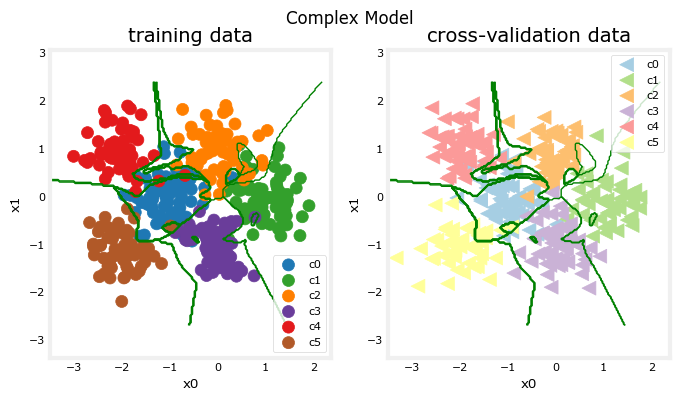

In [34]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

In [35]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 556us/step
categorization error, training, complex model: 0.005
categorization error, cv,       complex model: 0.122


In [36]:
tf.random.set_seed(1234)

model_s = Sequential([
    Dense(units=6, activation='relu'),
    Dense(units=6, activation='linear')
])

model_s.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.01))

In [37]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 583us/step - loss: 1.7306
Epoch 2/1000
13/13 [==============================] - 0s 584us/step - loss: 1.4468
Epoch 3/1000
13/13 [==============================] - 0s 583us/step - loss: 1.2902
Epoch 4/1000
13/13 [==============================] - 0s 583us/step - loss: 1.1367
Epoch 5/1000
13/13 [==============================] - 0s 500us/step - loss: 0.9710
Epoch 6/1000
13/13 [==============================] - 0s 583us/step - loss: 0.7947
Epoch 7/1000
13/13 [==============================] - 0s 750us/step - loss: 0.6499
Epoch 8/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5378
Epoch 9/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4652
Epoch 10/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4184
Epoch 11/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3860
Epoch 12/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3641
E

13/13 [==============================] - 0s 583us/step - loss: 0.2031
Epoch 99/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1991
Epoch 100/1000
13/13 [==============================] - 0s 500us/step - loss: 0.2006
Epoch 101/1000
13/13 [==============================] - 0s 580us/step - loss: 0.2010
Epoch 102/1000
13/13 [==============================] - 0s 584us/step - loss: 0.2018
Epoch 103/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2026
Epoch 104/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1988
Epoch 105/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1974
Epoch 106/1000
13/13 [==============================] - 0s 608us/step - loss: 0.1966
Epoch 107/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1963
Epoch 108/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1969
Epoch 109/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1

13/13 [==============================] - 0s 583us/step - loss: 0.1857
Epoch 195/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1859
Epoch 196/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1856
Epoch 197/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1879
Epoch 198/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1884
Epoch 199/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1894
Epoch 200/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1860
Epoch 201/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1869
Epoch 202/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1837
Epoch 203/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1861
Epoch 204/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1869
Epoch 205/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

13/13 [==============================] - 0s 522us/step - loss: 0.1807
Epoch 291/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1801
Epoch 292/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1793
Epoch 293/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1815
Epoch 294/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1784
Epoch 295/1000
13/13 [==============================] - 0s 568us/step - loss: 0.1867
Epoch 296/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1805
Epoch 297/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1855
Epoch 298/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1816
Epoch 299/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1798
Epoch 300/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1817
Epoch 301/1000
13/13 [==============================] - 0s 500us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.1781
Epoch 387/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1771
Epoch 388/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1809
Epoch 389/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1807
Epoch 390/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1792
Epoch 391/1000
13/13 [==============================] - 0s 624us/step - loss: 0.1767
Epoch 392/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1767
Epoch 393/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1763
Epoch 394/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1768
Epoch 395/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1789
Epoch 396/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1801
Epoch 397/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 500us/step - loss: 0.1745
Epoch 483/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1763
Epoch 484/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1767
Epoch 485/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1780
Epoch 486/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1739
Epoch 487/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1781
Epoch 488/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1755
Epoch 489/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1766
Epoch 490/1000
13/13 [==============================] - 0s 567us/step - loss: 0.1783
Epoch 491/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1769
Epoch 492/1000
13/13 [==============================] - 0s 587us/step - loss: 0.1752
Epoch 493/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.1741
Epoch 579/1000
13/13 [==============================] - 0s 704us/step - loss: 0.1732
Epoch 580/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1725
Epoch 581/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1709
Epoch 583/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1727
Epoch 584/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1742
Epoch 585/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1721
Epoch 586/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1730
Epoch 587/1000
13/13 [==============================] - 0s 693us/step - loss: 0.1728
Epoch 588/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1718
Epoch 589/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 608us/step - loss: 0.1740
Epoch 675/1000
13/13 [==============================] - 0s 538us/step - loss: 0.1699
Epoch 676/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1712
Epoch 677/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1711
Epoch 678/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1718
Epoch 679/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1795
Epoch 680/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1709
Epoch 681/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1703
Epoch 682/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1717
Epoch 683/1000
13/13 [==============================] - 0s 645us/step - loss: 0.1758
Epoch 684/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1699
Epoch 685/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.1693
Epoch 771/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1708
Epoch 772/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1693
Epoch 773/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1697
Epoch 774/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1712
Epoch 775/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1704
Epoch 776/1000
13/13 [==============================] - 0s 563us/step - loss: 0.1681
Epoch 777/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1704
Epoch 778/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1721
Epoch 779/1000
13/13 [==============================] - 0s 520us/step - loss: 0.1706
Epoch 780/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1747
Epoch 781/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.1702
Epoch 867/1000
13/13 [==============================] - 0s 619us/step - loss: 0.1695
Epoch 868/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1728
Epoch 869/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1682
Epoch 870/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1681
Epoch 871/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1684
Epoch 872/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1680
Epoch 873/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1720
Epoch 874/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1705
Epoch 875/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1686
Epoch 876/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1676
Epoch 877/1000
13/13 [==============================] - 0s 627us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.1667
Epoch 963/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1757
Epoch 964/1000
13/13 [==============================] - 0s 500us/step - loss: 0.1661
Epoch 965/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1713
Epoch 966/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1671
Epoch 967/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1697
Epoch 968/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1716
Epoch 969/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1688
Epoch 970/1000
13/13 [==============================] - 0s 584us/step - loss: 0.1672
Epoch 971/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1664
Epoch 972/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1684
Epoch 973/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

In [38]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 6)                 18        
                                                                 
 dense_10 (Dense)            (None, 6)                 42        
                                                                 
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
All tests passed!


1082/1082 [==============================] - 0s 411us/step


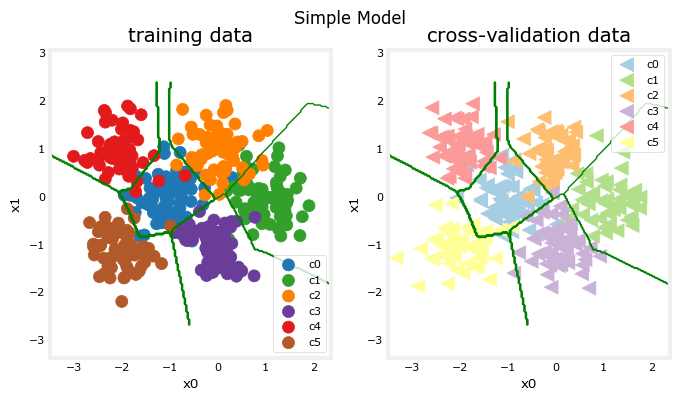

In [39]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

In [40]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 445us/step
categorization error, training, simple model, 0.062, complex model: 0.005
categorization error, cv,       simple model, 0.087, complex model: 0.122


In [41]:
tf.random.set_seed(1234)

model_r = Sequential([
    Dense(units=120, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)), # lambda = 0.1
    Dense(units=40, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    Dense(units=6, activation='linear')
])

model_r.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.01))

In [42]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 750us/step - loss: 4.4464
Epoch 2/1000
13/13 [==============================] - 0s 681us/step - loss: 1.7086
Epoch 3/1000
13/13 [==============================] - 0s 729us/step - loss: 1.3465
Epoch 4/1000
13/13 [==============================] - 0s 719us/step - loss: 1.0870
Epoch 5/1000
13/13 [==============================] - 0s 745us/step - loss: 1.0137
Epoch 6/1000
13/13 [==============================] - 0s 750us/step - loss: 0.9718
Epoch 7/1000
13/13 [==============================] - 0s 667us/step - loss: 0.9481
Epoch 8/1000
13/13 [==============================] - 0s 717us/step - loss: 0.8934
Epoch 9/1000
13/13 [==============================] - 0s 714us/step - loss: 0.8171
Epoch 10/1000
13/13 [==============================] - 0s 641us/step - loss: 0.7715
Epoch 11/1000
13/13 [==============================] - 0s 754us/step - loss: 0.7611
Epoch 12/1000
13/13 [==============================] - 0s 750us/step - loss: 0.7521
E

13/13 [==============================] - 0s 667us/step - loss: 0.4669
Epoch 99/1000
13/13 [==============================] - 0s 712us/step - loss: 0.4961
Epoch 100/1000
13/13 [==============================] - 0s 640us/step - loss: 0.4954
Epoch 101/1000
13/13 [==============================] - 0s 692us/step - loss: 0.4874
Epoch 102/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4759
Epoch 103/1000
13/13 [==============================] - 0s 714us/step - loss: 0.4739
Epoch 104/1000
13/13 [==============================] - 0s 781us/step - loss: 0.4682
Epoch 105/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5125
Epoch 106/1000
13/13 [==============================] - 0s 631us/step - loss: 0.4548
Epoch 107/1000
13/13 [==============================] - 0s 710us/step - loss: 0.4610
Epoch 108/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4702
Epoch 109/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4

13/13 [==============================] - 0s 750us/step - loss: 0.4158
Epoch 195/1000
13/13 [==============================] - 0s 721us/step - loss: 0.4026
Epoch 196/1000
13/13 [==============================] - 0s 801us/step - loss: 0.3953
Epoch 197/1000
13/13 [==============================] - 0s 832us/step - loss: 0.4191
Epoch 198/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3963
Epoch 199/1000
13/13 [==============================] - 0s 777us/step - loss: 0.4080
Epoch 200/1000
13/13 [==============================] - 0s 709us/step - loss: 0.4032
Epoch 201/1000
13/13 [==============================] - 0s 750us/step - loss: 0.4268
Epoch 202/1000
13/13 [==============================] - 0s 688us/step - loss: 0.3954
Epoch 203/1000
13/13 [==============================] - 0s 836us/step - loss: 0.3980
Epoch 204/1000
13/13 [==============================] - 0s 828us/step - loss: 0.4088
Epoch 205/1000
13/13 [==============================] - 0s 747us/step - loss: 0.

13/13 [==============================] - 0s 747us/step - loss: 0.3892
Epoch 291/1000
13/13 [==============================] - 0s 839us/step - loss: 0.3911
Epoch 292/1000
13/13 [==============================] - 0s 740us/step - loss: 0.3697
Epoch 293/1000
13/13 [==============================] - 0s 712us/step - loss: 0.3800
Epoch 294/1000
13/13 [==============================] - 0s 686us/step - loss: 0.4007
Epoch 295/1000
13/13 [==============================] - 0s 742us/step - loss: 0.4066
Epoch 296/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3768
Epoch 297/1000
13/13 [==============================] - 0s 764us/step - loss: 0.3841
Epoch 298/1000
13/13 [==============================] - 0s 773us/step - loss: 0.3884
Epoch 299/1000
13/13 [==============================] - 0s 659us/step - loss: 0.3926
Epoch 300/1000
13/13 [==============================] - 0s 703us/step - loss: 0.4250
Epoch 301/1000
13/13 [==============================] - 0s 653us/step - loss: 0.

13/13 [==============================] - 0s 713us/step - loss: 0.3574
Epoch 387/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3764
Epoch 388/1000
13/13 [==============================] - 0s 762us/step - loss: 0.3717
Epoch 389/1000
13/13 [==============================] - 0s 792us/step - loss: 0.3674
Epoch 390/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3531
Epoch 391/1000
13/13 [==============================] - 0s 725us/step - loss: 0.3664
Epoch 392/1000
13/13 [==============================] - 0s 636us/step - loss: 0.3819
Epoch 393/1000
13/13 [==============================] - 0s 608us/step - loss: 0.3605
Epoch 394/1000
13/13 [==============================] - 0s 676us/step - loss: 0.3635
Epoch 395/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3932
Epoch 396/1000
13/13 [==============================] - 0s 671us/step - loss: 0.3799
Epoch 397/1000
13/13 [==============================] - 0s 698us/step - loss: 0.

13/13 [==============================] - 0s 818us/step - loss: 0.3755
Epoch 483/1000
13/13 [==============================] - 0s 859us/step - loss: 0.3802
Epoch 484/1000
13/13 [==============================] - 0s 826us/step - loss: 0.3782
Epoch 485/1000
13/13 [==============================] - 0s 841us/step - loss: 0.3808
Epoch 486/1000
13/13 [==============================] - 0s 811us/step - loss: 0.3564
Epoch 487/1000
13/13 [==============================] - 0s 913us/step - loss: 0.3470
Epoch 488/1000
13/13 [==============================] - 0s 824us/step - loss: 0.3539
Epoch 489/1000
13/13 [==============================] - 0s 812us/step - loss: 0.3401
Epoch 490/1000
13/13 [==============================] - 0s 809us/step - loss: 0.3561
Epoch 491/1000
13/13 [==============================] - 0s 794us/step - loss: 0.3693
Epoch 492/1000
13/13 [==============================] - 0s 849us/step - loss: 0.3690
Epoch 493/1000
13/13 [==============================] - 0s 801us/step - loss: 0.

13/13 [==============================] - 0s 746us/step - loss: 0.4221
Epoch 579/1000
13/13 [==============================] - 0s 788us/step - loss: 0.3583
Epoch 580/1000
13/13 [==============================] - 0s 790us/step - loss: 0.3376
Epoch 581/1000
13/13 [==============================] - 0s 924us/step - loss: 0.3628
Epoch 582/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3540
Epoch 583/1000
13/13 [==============================] - 0s 770us/step - loss: 0.3571
Epoch 584/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3818
Epoch 585/1000
13/13 [==============================] - 0s 734us/step - loss: 0.3954
Epoch 586/1000
13/13 [==============================] - 0s 717us/step - loss: 0.3669
Epoch 587/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3536
Epoch 588/1000
13/13 [==============================] - 0s 780us/step - loss: 0.3407
Epoch 589/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 723us/step - loss: 0.4009
Epoch 675/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3426
Epoch 676/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3406
Epoch 677/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3369
Epoch 678/1000
13/13 [==============================] - 0s 761us/step - loss: 0.3356
Epoch 679/1000
13/13 [==============================] - 0s 851us/step - loss: 0.3463
Epoch 680/1000
13/13 [==============================] - 0s 915us/step - loss: 0.3406
Epoch 681/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3549
Epoch 682/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3399
Epoch 683/1000
13/13 [==============================] - 0s 834us/step - loss: 0.3363
Epoch 684/1000
13/13 [==============================] - 0s 814us/step - loss: 0.3415
Epoch 685/1000
13/13 [==============================] - 0s 851us/step - loss: 0.

13/13 [==============================] - 0s 766us/step - loss: 0.3301
Epoch 771/1000
13/13 [==============================] - 0s 799us/step - loss: 0.3454
Epoch 772/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3471
Epoch 773/1000
13/13 [==============================] - 0s 716us/step - loss: 0.3825
Epoch 774/1000
13/13 [==============================] - 0s 672us/step - loss: 0.3659
Epoch 775/1000
13/13 [==============================] - 0s 674us/step - loss: 0.3377
Epoch 776/1000
13/13 [==============================] - 0s 673us/step - loss: 0.3882
Epoch 777/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3705
Epoch 778/1000
13/13 [==============================] - 0s 669us/step - loss: 0.3279
Epoch 779/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3339
Epoch 780/1000
13/13 [==============================] - 0s 650us/step - loss: 0.3435
Epoch 781/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.3725
Epoch 867/1000
13/13 [==============================] - 0s 713us/step - loss: 0.3334
Epoch 868/1000
13/13 [==============================] - 0s 696us/step - loss: 0.3360
Epoch 869/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3430
Epoch 870/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3601
Epoch 871/1000
13/13 [==============================] - 0s 720us/step - loss: 0.3625
Epoch 872/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3410
Epoch 873/1000
13/13 [==============================] - 0s 662us/step - loss: 0.3373
Epoch 874/1000
13/13 [==============================] - 0s 731us/step - loss: 0.3479
Epoch 875/1000
13/13 [==============================] - 0s 763us/step - loss: 0.3524
Epoch 876/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3360
Epoch 877/1000
13/13 [==============================] - 0s 689us/step - loss: 0.

13/13 [==============================] - 0s 745us/step - loss: 0.3196
Epoch 963/1000
13/13 [==============================] - 0s 832us/step - loss: 0.3408
Epoch 964/1000
13/13 [==============================] - 0s 917us/step - loss: 0.3208
Epoch 965/1000
13/13 [==============================] - 0s 702us/step - loss: 0.3241
Epoch 966/1000
13/13 [==============================] - 0s 797us/step - loss: 0.3396
Epoch 967/1000
13/13 [==============================] - 0s 783us/step - loss: 0.3292
Epoch 968/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3362
Epoch 969/1000
13/13 [==============================] - 0s 752us/step - loss: 0.3866
Epoch 970/1000
13/13 [==============================] - 0s 785us/step - loss: 0.3795
Epoch 971/1000
13/13 [==============================] - 0s 737us/step - loss: 0.3494
Epoch 972/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3260
Epoch 973/1000
13/13 [==============================] - 0s 661us/step - loss: 0.

In [43]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 120)               360       
                                                                 
 dense_12 (Dense)            (None, 40)                4840      
                                                                 
 dense_13 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
ddd
All tests passed!


1082/1082 [==============================] - 0s 437us/step


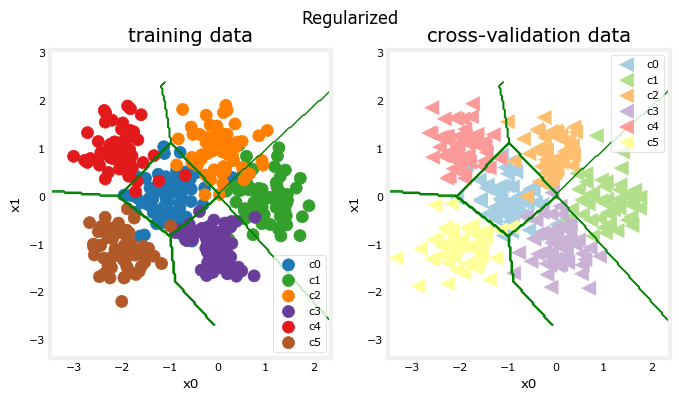

In [44]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

In [45]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 1ms/step
categorization error, training, regularized: 0.072, simple model, 0.062, complex model: 0.005
categorization error, cv,       regularized: 0.066, simple model, 0.087, complex model: 0.122


In [46]:
# Find optimal lambda (regularization)

tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")

Epoch 1/1000
13/13 [==============================] - 0s 783us/step - loss: 1.1106
Epoch 2/1000
13/13 [==============================] - 0s 718us/step - loss: 0.4281
Epoch 3/1000
13/13 [==============================] - 0s 746us/step - loss: 0.3345
Epoch 4/1000
13/13 [==============================] - 0s 690us/step - loss: 0.2896
Epoch 5/1000
13/13 [==============================] - 0s 701us/step - loss: 0.2867
Epoch 6/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2918
Epoch 7/1000
13/13 [==============================] - 0s 636us/step - loss: 0.2497
Epoch 8/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2298
Epoch 9/1000
13/13 [==============================] - 0s 636us/step - loss: 0.2307
Epoch 10/1000
13/13 [==============================] - 0s 698us/step - loss: 0.2071
Epoch 11/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2115
Epoch 12/1000
13/13 [==============================] - 0s 650us/step - loss: 0.2070
E

13/13 [==============================] - 0s 750us/step - loss: 0.1855
Epoch 99/1000
13/13 [==============================] - 0s 616us/step - loss: 0.1685
Epoch 100/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1569
Epoch 101/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1645
Epoch 102/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1737
Epoch 103/1000
13/13 [==============================] - 0s 677us/step - loss: 0.1935
Epoch 104/1000
13/13 [==============================] - 0s 618us/step - loss: 0.1600
Epoch 105/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1483
Epoch 106/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1555
Epoch 107/1000
13/13 [==============================] - 0s 672us/step - loss: 0.1678
Epoch 108/1000
13/13 [==============================] - 0s 583us/step - loss: 0.1435
Epoch 109/1000
13/13 [==============================] - 0s 701us/step - loss: 0.1

13/13 [==============================] - 0s 667us/step - loss: 0.0890
Epoch 195/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0880
Epoch 196/1000
13/13 [==============================] - 0s 581us/step - loss: 0.1006
Epoch 197/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0974
Epoch 198/1000
13/13 [==============================] - 0s 661us/step - loss: 0.1141
Epoch 199/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 640us/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 638us/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 671us/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 751us/step - loss: 0.0682
Epoch 291/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0745
Epoch 292/1000
13/13 [==============================] - 0s 805us/step - loss: 0.0848
Epoch 293/1000
13/13 [==============================] - 0s 717us/step - loss: 0.0701
Epoch 294/1000
13/13 [==============================] - 0s 656us/step - loss: 0.0828
Epoch 295/1000
13/13 [==============================] - 0s 703us/step - loss: 0.0741
Epoch 296/1000
13/13 [==============================] - 0s 691us/step - loss: 0.0890
Epoch 297/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 775us/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 774us/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 628us/step - loss: 0.

13/13 [==============================] - 0s 653us/step - loss: 0.0391
Epoch 387/1000
13/13 [==============================] - 0s 634us/step - loss: 0.0394
Epoch 388/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0510
Epoch 389/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0525
Epoch 390/1000
13/13 [==============================] - 0s 625us/step - loss: 0.0666
Epoch 391/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0490
Epoch 392/1000
13/13 [==============================] - 0s 634us/step - loss: 0.0551
Epoch 393/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0689
Epoch 394/1000
13/13 [==============================] - 0s 663us/step - loss: 0.0663
Epoch 395/1000
13/13 [==============================] - 0s 640us/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 748us/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 786us/step - loss: 0.

13/13 [==============================] - 0s 775us/step - loss: 0.1244
Epoch 483/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2012
Epoch 484/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1340
Epoch 485/1000
13/13 [==============================] - 0s 803us/step - loss: 0.1073
Epoch 486/1000
13/13 [==============================] - 0s 760us/step - loss: 0.1045
Epoch 487/1000
13/13 [==============================] - 0s 759us/step - loss: 0.0974
Epoch 488/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0763
Epoch 489/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0694
Epoch 490/1000
13/13 [==============================] - 0s 790us/step - loss: 0.0751
Epoch 491/1000
13/13 [==============================] - 0s 793us/step - loss: 0.0742
Epoch 492/1000
13/13 [==============================] - 0s 806us/step - loss: 0.0639
Epoch 493/1000
13/13 [==============================] - 0s 819us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.0546
Epoch 579/1000
13/13 [==============================] - 0s 717us/step - loss: 0.0465
Epoch 580/1000
13/13 [==============================] - 0s 795us/step - loss: 0.0494
Epoch 581/1000
13/13 [==============================] - 0s 786us/step - loss: 0.0437
Epoch 582/1000
13/13 [==============================] - 0s 772us/step - loss: 0.0365
Epoch 583/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0440
Epoch 584/1000
13/13 [==============================] - 0s 724us/step - loss: 0.0351
Epoch 585/1000
13/13 [==============================] - 0s 729us/step - loss: 0.0345
Epoch 586/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0368
Epoch 587/1000
13/13 [==============================] - 0s 697us/step - loss: 0.0349
Epoch 588/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0332
Epoch 589/1000
13/13 [==============================] - 0s 728us/step - loss: 0.

13/13 [==============================] - 0s 794us/step - loss: 0.0301
Epoch 675/1000
13/13 [==============================] - 0s 831us/step - loss: 0.0311
Epoch 676/1000
13/13 [==============================] - 0s 756us/step - loss: 0.0333
Epoch 677/1000
13/13 [==============================] - 0s 722us/step - loss: 0.0355
Epoch 678/1000
13/13 [==============================] - 0s 716us/step - loss: 0.0584
Epoch 679/1000
13/13 [==============================] - 0s 834us/step - loss: 0.0370
Epoch 680/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0710
Epoch 681/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0570
Epoch 682/1000
13/13 [==============================] - 0s 776us/step - loss: 0.0461
Epoch 683/1000
13/13 [==============================] - 0s 875us/step - loss: 0.0635
Epoch 684/1000
13/13 [==============================] - 0s 899us/step - loss: 0.0711
Epoch 685/1000
13/13 [==============================] - 0s 819us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.1385
Epoch 771/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2209
Epoch 772/1000
13/13 [==============================] - 0s 777us/step - loss: 0.2095
Epoch 773/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1876
Epoch 774/1000
13/13 [==============================] - 0s 840us/step - loss: 0.1609
Epoch 775/1000
13/13 [==============================] - 0s 748us/step - loss: 0.1213
Epoch 776/1000
13/13 [==============================] - 0s 775us/step - loss: 0.1153
Epoch 777/1000
13/13 [==============================] - 0s 728us/step - loss: 0.1085
Epoch 778/1000
13/13 [==============================] - 0s 735us/step - loss: 0.0899
Epoch 779/1000
13/13 [==============================] - 0s 756us/step - loss: 0.0760
Epoch 780/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0901
Epoch 781/1000
13/13 [==============================] - 0s 751us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.0226
Epoch 867/1000
13/13 [==============================] - 0s 718us/step - loss: 0.0249
Epoch 868/1000
13/13 [==============================] - 0s 710us/step - loss: 0.0218
Epoch 869/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0255
Epoch 870/1000
13/13 [==============================] - 0s 634us/step - loss: 0.0471
Epoch 871/1000
13/13 [==============================] - 0s 708us/step - loss: 0.0250
Epoch 872/1000
13/13 [==============================] - 0s 636us/step - loss: 0.0552
Epoch 873/1000
13/13 [==============================] - 0s 693us/step - loss: 0.0358
Epoch 874/1000
13/13 [==============================] - 0s 644us/step - loss: 0.0439
Epoch 875/1000
13/13 [==============================] - 0s 692us/step - loss: 0.0497
Epoch 876/1000
13/13 [==============================] - 0s 667us/step - loss: 0.0929
Epoch 877/1000
13/13 [==============================] - 0s 608us/step - loss: 0.

13/13 [==============================] - 0s 660us/step - loss: 0.0183
Epoch 963/1000
13/13 [==============================] - 0s 689us/step - loss: 0.0205
Epoch 964/1000
13/13 [==============================] - 0s 750us/step - loss: 0.0213
Epoch 965/1000
13/13 [==============================] - 0s 635us/step - loss: 0.0213
Epoch 966/1000
13/13 [==============================] - 0s 677us/step - loss: 0.0188
Epoch 967/1000
13/13 [==============================] - 0s 605us/step - loss: 0.0232
Epoch 968/1000
13/13 [==============================] - 0s 609us/step - loss: 0.0205
Epoch 969/1000
13/13 [==============================] - 0s 664us/step - loss: 0.0188
Epoch 970/1000
13/13 [==============================] - 0s 684us/step - loss: 0.0180
Epoch 971/1000
13/13 [==============================] - 0s 627us/step - loss: 0.0182
Epoch 972/1000
13/13 [==============================] - 0s 683us/step - loss: 0.0160
Epoch 973/1000
13/13 [==============================] - 0s 616us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.2588
Epoch 60/1000
13/13 [==============================] - 0s 724us/step - loss: 0.2569
Epoch 61/1000
13/13 [==============================] - 0s 777us/step - loss: 0.2475
Epoch 62/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2257
Epoch 63/1000
13/13 [==============================] - 0s 791us/step - loss: 0.2267
Epoch 64/1000
13/13 [==============================] - 0s 828us/step - loss: 0.2697
Epoch 65/1000
13/13 [==============================] - 0s 792us/step - loss: 0.2643
Epoch 66/1000
13/13 [==============================] - 0s 810us/step - loss: 0.2571
Epoch 67/1000
13/13 [==============================] - 0s 783us/step - loss: 0.2815
Epoch 68/1000
13/13 [==============================] - 0s 801us/step - loss: 0.2878
Epoch 69/1000
13/13 [==============================] - 0s 787us/step - loss: 0.2394
Epoch 70/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2338
Epoch 

13/13 [==============================] - 0s 734us/step - loss: 0.2131
Epoch 157/1000
13/13 [==============================] - 0s 867us/step - loss: 0.2189
Epoch 158/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2196
Epoch 159/1000
13/13 [==============================] - 0s 834us/step - loss: 0.2014
Epoch 160/1000
13/13 [==============================] - 0s 786us/step - loss: 0.2044
Epoch 161/1000
13/13 [==============================] - 0s 845us/step - loss: 0.2024
Epoch 162/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2071
Epoch 163/1000
13/13 [==============================] - 0s 894us/step - loss: 0.2171
Epoch 164/1000
13/13 [==============================] - 0s 745us/step - loss: 0.2202
Epoch 165/1000
13/13 [==============================] - 0s 710us/step - loss: 0.2135
Epoch 166/1000
13/13 [==============================] - 0s 748us/step - loss: 0.2072
Epoch 167/1000
13/13 [==============================] - 0s 801us/step - loss: 0.

13/13 [==============================] - 0s 770us/step - loss: 0.1904
Epoch 253/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1942
Epoch 254/1000
13/13 [==============================] - 0s 756us/step - loss: 0.2016
Epoch 255/1000
13/13 [==============================] - 0s 779us/step - loss: 0.1996
Epoch 256/1000
13/13 [==============================] - 0s 873us/step - loss: 0.1887
Epoch 257/1000
13/13 [==============================] - 0s 833us/step - loss: 0.2110
Epoch 258/1000
13/13 [==============================] - 0s 823us/step - loss: 0.2040
Epoch 259/1000
13/13 [==============================] - 0s 798us/step - loss: 0.1890
Epoch 260/1000
13/13 [==============================] - 0s 862us/step - loss: 0.1960
Epoch 261/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2038
Epoch 262/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1948
Epoch 263/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 794us/step - loss: 0.1930
Epoch 349/1000
13/13 [==============================] - 0s 827us/step - loss: 0.1804
Epoch 350/1000
13/13 [==============================] - 0s 852us/step - loss: 0.1765
Epoch 351/1000
13/13 [==============================] - 0s 768us/step - loss: 0.1839
Epoch 352/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1919
Epoch 353/1000
13/13 [==============================] - 0s 761us/step - loss: 0.1982
Epoch 354/1000
13/13 [==============================] - 0s 776us/step - loss: 0.1934
Epoch 355/1000
13/13 [==============================] - 0s 716us/step - loss: 0.1957
Epoch 356/1000
13/13 [==============================] - 0s 797us/step - loss: 0.1822
Epoch 357/1000
13/13 [==============================] - 0s 763us/step - loss: 0.1815
Epoch 358/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1859
Epoch 359/1000
13/13 [==============================] - 0s 736us/step - loss: 0.

13/13 [==============================] - 0s 829us/step - loss: 0.1697
Epoch 445/1000
13/13 [==============================] - 0s 868us/step - loss: 0.1742
Epoch 446/1000
13/13 [==============================] - 0s 857us/step - loss: 0.1905
Epoch 447/1000
13/13 [==============================] - 0s 794us/step - loss: 0.1883
Epoch 448/1000
13/13 [==============================] - 0s 809us/step - loss: 0.1722
Epoch 449/1000
13/13 [==============================] - 0s 850us/step - loss: 0.1719
Epoch 450/1000
13/13 [==============================] - 0s 829us/step - loss: 0.1731
Epoch 451/1000
13/13 [==============================] - 0s 753us/step - loss: 0.1819
Epoch 452/1000
13/13 [==============================] - 0s 843us/step - loss: 0.1721
Epoch 453/1000
13/13 [==============================] - 0s 732us/step - loss: 0.1752
Epoch 454/1000
13/13 [==============================] - 0s 785us/step - loss: 0.1742
Epoch 455/1000
13/13 [==============================] - 0s 733us/step - loss: 0.

13/13 [==============================] - 0s 730us/step - loss: 0.1730
Epoch 541/1000
13/13 [==============================] - 0s 778us/step - loss: 0.1869
Epoch 542/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1679
Epoch 543/1000
13/13 [==============================] - 0s 795us/step - loss: 0.1635
Epoch 544/1000
13/13 [==============================] - 0s 726us/step - loss: 0.1683
Epoch 545/1000
13/13 [==============================] - 0s 779us/step - loss: 0.1704
Epoch 546/1000
13/13 [==============================] - 0s 793us/step - loss: 0.1692
Epoch 547/1000
13/13 [==============================] - 0s 746us/step - loss: 0.1742
Epoch 548/1000
13/13 [==============================] - 0s 786us/step - loss: 0.1743
Epoch 549/1000
13/13 [==============================] - 0s 803us/step - loss: 0.1815
Epoch 550/1000
13/13 [==============================] - 0s 856us/step - loss: 0.1871
Epoch 551/1000
13/13 [==============================] - 0s 834us/step - loss: 0.

13/13 [==============================] - 0s 830us/step - loss: 0.1724
Epoch 637/1000
13/13 [==============================] - 0s 842us/step - loss: 0.1782
Epoch 638/1000
13/13 [==============================] - 0s 851us/step - loss: 0.1818
Epoch 639/1000
13/13 [==============================] - 0s 713us/step - loss: 0.1664
Epoch 640/1000
13/13 [==============================] - 0s 798us/step - loss: 0.1669
Epoch 641/1000
13/13 [==============================] - 0s 818us/step - loss: 0.1659
Epoch 642/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1644
Epoch 643/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1588
Epoch 644/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1608
Epoch 645/1000
13/13 [==============================] - 0s 834us/step - loss: 0.1689
Epoch 646/1000
13/13 [==============================] - 0s 848us/step - loss: 0.1672
Epoch 647/1000
13/13 [==============================] - 0s 834us/step - loss: 0.16

13/13 [==============================] - 0s 695us/step - loss: 0.1737
Epoch 733/1000
13/13 [==============================] - 0s 695us/step - loss: 0.1638
Epoch 734/1000
13/13 [==============================] - 0s 665us/step - loss: 0.1744
Epoch 735/1000
13/13 [==============================] - 0s 712us/step - loss: 0.1693
Epoch 736/1000
13/13 [==============================] - 0s 732us/step - loss: 0.1695
Epoch 737/1000
13/13 [==============================] - 0s 652us/step - loss: 0.1631
Epoch 738/1000
13/13 [==============================] - 0s 720us/step - loss: 0.1742
Epoch 739/1000
13/13 [==============================] - 0s 695us/step - loss: 0.1813
Epoch 740/1000
13/13 [==============================] - 0s 721us/step - loss: 0.1670
Epoch 741/1000
13/13 [==============================] - 0s 702us/step - loss: 0.1670
Epoch 742/1000
13/13 [==============================] - 0s 722us/step - loss: 0.1608
Epoch 743/1000
13/13 [==============================] - 0s 596us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.1644
Epoch 829/1000
13/13 [==============================] - 0s 779us/step - loss: 0.1603
Epoch 830/1000
13/13 [==============================] - 0s 782us/step - loss: 0.1512
Epoch 831/1000
13/13 [==============================] - 0s 755us/step - loss: 0.1601
Epoch 832/1000
13/13 [==============================] - 0s 772us/step - loss: 0.1531
Epoch 833/1000
13/13 [==============================] - 0s 792us/step - loss: 0.1594
Epoch 834/1000
13/13 [==============================] - 0s 771us/step - loss: 0.1485
Epoch 835/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1524
Epoch 836/1000
13/13 [==============================] - 0s 746us/step - loss: 0.1528
Epoch 837/1000
13/13 [==============================] - 0s 785us/step - loss: 0.1516
Epoch 838/1000
13/13 [==============================] - 0s 803us/step - loss: 0.1574
Epoch 839/1000
13/13 [==============================] - 0s 850us/step - loss: 0.

13/13 [==============================] - 0s 728us/step - loss: 0.1500
Epoch 925/1000
13/13 [==============================] - 0s 672us/step - loss: 0.1457
Epoch 926/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1496
Epoch 927/1000
13/13 [==============================] - 0s 656us/step - loss: 0.1457
Epoch 928/1000
13/13 [==============================] - 0s 710us/step - loss: 0.1477
Epoch 929/1000
13/13 [==============================] - 0s 700us/step - loss: 0.1488
Epoch 930/1000
13/13 [==============================] - 0s 667us/step - loss: 0.1498
Epoch 931/1000
13/13 [==============================] - 0s 692us/step - loss: 0.1577
Epoch 932/1000
13/13 [==============================] - 0s 704us/step - loss: 0.1590
Epoch 933/1000
13/13 [==============================] - 0s 664us/step - loss: 0.1636
Epoch 934/1000
13/13 [==============================] - 0s 750us/step - loss: 0.1574
Epoch 935/1000
13/13 [==============================] - 0s 698us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3689
Epoch 21/1000
13/13 [==============================] - 0s 685us/step - loss: 0.3560
Epoch 22/1000
13/13 [==============================] - 0s 602us/step - loss: 0.3717
Epoch 23/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3560
Epoch 24/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3582
Epoch 25/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4461
Epoch 26/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4211
Epoch 27/1000
13/13 [==============================] - 0s 694us/step - loss: 0.4046
Epoch 28/1000
13/13 [==============================] - 0s 621us/step - loss: 0.3618
Epoch 29/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3376
Epoch 30/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3653
Epoch 31/1000
13/13 [==============================] - 0s 678us/step - loss: 0.3520
Epoch 

13/13 [==============================] - 0s 743us/step - loss: 0.2773
Epoch 118/1000
13/13 [==============================] - 0s 730us/step - loss: 0.2729
Epoch 119/1000
13/13 [==============================] - 0s 641us/step - loss: 0.2967
Epoch 120/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3043
Epoch 121/1000
13/13 [==============================] - 0s 746us/step - loss: 0.2981
Epoch 122/1000
13/13 [==============================] - 0s 712us/step - loss: 0.2903
Epoch 123/1000
13/13 [==============================] - 0s 780us/step - loss: 0.2808
Epoch 124/1000
13/13 [==============================] - 0s 841us/step - loss: 0.2722
Epoch 125/1000
13/13 [==============================] - 0s 721us/step - loss: 0.2721
Epoch 126/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2803
Epoch 127/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3002
Epoch 128/1000
13/13 [==============================] - 0s 646us/step - loss: 0.

13/13 [==============================] - 0s 683us/step - loss: 0.2654
Epoch 214/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2647
Epoch 215/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2613
Epoch 216/1000
13/13 [==============================] - 0s 630us/step - loss: 0.2652
Epoch 217/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2633
Epoch 218/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2727
Epoch 219/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2648
Epoch 220/1000
13/13 [==============================] - 0s 666us/step - loss: 0.2533
Epoch 221/1000
13/13 [==============================] - 0s 582us/step - loss: 0.2562
Epoch 222/1000
13/13 [==============================] - 0s 732us/step - loss: 0.2620
Epoch 223/1000
13/13 [==============================] - 0s 603us/step - loss: 0.2624
Epoch 224/1000
13/13 [==============================] - 0s 609us/step - loss: 0.

13/13 [==============================] - 0s 698us/step - loss: 0.2554
Epoch 310/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2507
Epoch 311/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2488
Epoch 312/1000
13/13 [==============================] - 0s 659us/step - loss: 0.2486
Epoch 313/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2906
Epoch 314/1000
13/13 [==============================] - 0s 674us/step - loss: 0.2616
Epoch 315/1000
13/13 [==============================] - 0s 622us/step - loss: 0.2615
Epoch 316/1000
13/13 [==============================] - 0s 705us/step - loss: 0.2564
Epoch 317/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2498
Epoch 318/1000
13/13 [==============================] - 0s 651us/step - loss: 0.2488
Epoch 319/1000
13/13 [==============================] - 0s 677us/step - loss: 0.2740
Epoch 320/1000
13/13 [==============================] - 0s 656us/step - loss: 0.

13/13 [==============================] - 0s 699us/step - loss: 0.2564
Epoch 406/1000
13/13 [==============================] - 0s 711us/step - loss: 0.2358
Epoch 407/1000
13/13 [==============================] - 0s 657us/step - loss: 0.2354
Epoch 408/1000
13/13 [==============================] - 0s 662us/step - loss: 0.2492
Epoch 409/1000
13/13 [==============================] - 0s 690us/step - loss: 0.2510
Epoch 410/1000
13/13 [==============================] - 0s 657us/step - loss: 0.2410
Epoch 411/1000
13/13 [==============================] - 0s 699us/step - loss: 0.2705
Epoch 412/1000
13/13 [==============================] - 0s 692us/step - loss: 0.2500
Epoch 413/1000
13/13 [==============================] - 0s 615us/step - loss: 0.2373
Epoch 414/1000
13/13 [==============================] - 0s 791us/step - loss: 0.2435
Epoch 415/1000
13/13 [==============================] - 0s 605us/step - loss: 0.2616
Epoch 416/1000
13/13 [==============================] - 0s 750us/step - loss: 0.

13/13 [==============================] - 0s 748us/step - loss: 0.2426
Epoch 502/1000
13/13 [==============================] - 0s 663us/step - loss: 0.2469
Epoch 503/1000
13/13 [==============================] - 0s 662us/step - loss: 0.2586
Epoch 504/1000
13/13 [==============================] - 0s 642us/step - loss: 0.2434
Epoch 505/1000
13/13 [==============================] - 0s 654us/step - loss: 0.2349
Epoch 506/1000
13/13 [==============================] - 0s 563us/step - loss: 0.2417
Epoch 507/1000
13/13 [==============================] - 0s 654us/step - loss: 0.2423
Epoch 508/1000
13/13 [==============================] - 0s 620us/step - loss: 0.2325
Epoch 509/1000
13/13 [==============================] - 0s 700us/step - loss: 0.2506
Epoch 510/1000
13/13 [==============================] - 0s 704us/step - loss: 0.2414
Epoch 511/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2281
Epoch 512/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 626us/step - loss: 0.2413
Epoch 598/1000
13/13 [==============================] - 0s 637us/step - loss: 0.2448
Epoch 599/1000
13/13 [==============================] - 0s 615us/step - loss: 0.2390
Epoch 600/1000
13/13 [==============================] - 0s 689us/step - loss: 0.2366
Epoch 601/1000
13/13 [==============================] - 0s 643us/step - loss: 0.2245
Epoch 602/1000
13/13 [==============================] - 0s 715us/step - loss: 0.2445
Epoch 603/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2743
Epoch 604/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2642
Epoch 605/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2378
Epoch 606/1000
13/13 [==============================] - 0s 588us/step - loss: 0.2433
Epoch 607/1000
13/13 [==============================] - 0s 590us/step - loss: 0.2302
Epoch 608/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 669us/step - loss: 0.2293
Epoch 694/1000
13/13 [==============================] - 0s 678us/step - loss: 0.2335
Epoch 695/1000
13/13 [==============================] - 0s 638us/step - loss: 0.2300
Epoch 696/1000
13/13 [==============================] - 0s 604us/step - loss: 0.2249
Epoch 697/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2279
Epoch 698/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2341
Epoch 699/1000
13/13 [==============================] - 0s 668us/step - loss: 0.2225
Epoch 700/1000
13/13 [==============================] - 0s 657us/step - loss: 0.2300
Epoch 701/1000
13/13 [==============================] - 0s 694us/step - loss: 0.2200
Epoch 702/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2195
Epoch 703/1000
13/13 [==============================] - 0s 589us/step - loss: 0.2355
Epoch 704/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 651us/step - loss: 0.2213
Epoch 790/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2240
Epoch 791/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2255
Epoch 792/1000
13/13 [==============================] - 0s 671us/step - loss: 0.2294
Epoch 793/1000
13/13 [==============================] - 0s 618us/step - loss: 0.2198
Epoch 794/1000
13/13 [==============================] - 0s 666us/step - loss: 0.2319
Epoch 795/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2169
Epoch 796/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2390
Epoch 797/1000
13/13 [==============================] - 0s 627us/step - loss: 0.2281
Epoch 798/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2324
Epoch 799/1000
13/13 [==============================] - 0s 602us/step - loss: 0.2183
Epoch 800/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 618us/step - loss: 0.2339
Epoch 886/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2193
Epoch 887/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2172
Epoch 888/1000
13/13 [==============================] - 0s 617us/step - loss: 0.2284
Epoch 889/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2224
Epoch 890/1000
13/13 [==============================] - 0s 616us/step - loss: 0.2220
Epoch 891/1000
13/13 [==============================] - 0s 750us/step - loss: 0.2212
Epoch 892/1000
13/13 [==============================] - 0s 648us/step - loss: 0.2136
Epoch 893/1000
13/13 [==============================] - 0s 589us/step - loss: 0.2337
Epoch 894/1000
13/13 [==============================] - 0s 648us/step - loss: 0.2264
Epoch 895/1000
13/13 [==============================] - 0s 643us/step - loss: 0.2330
Epoch 896/1000
13/13 [==============================] - 0s 605us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.2097
Epoch 982/1000
13/13 [==============================] - 0s 710us/step - loss: 0.2217
Epoch 983/1000
13/13 [==============================] - 0s 633us/step - loss: 0.2284
Epoch 984/1000
13/13 [==============================] - 0s 636us/step - loss: 0.2144
Epoch 985/1000
13/13 [==============================] - 0s 636us/step - loss: 0.2173
Epoch 986/1000
13/13 [==============================] - 0s 600us/step - loss: 0.2212
Epoch 987/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2123
Epoch 988/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2157
Epoch 989/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2375
Epoch 990/1000
13/13 [==============================] - 0s 665us/step - loss: 0.2285
Epoch 991/1000
13/13 [==============================] - 0s 583us/step - loss: 0.2383
Epoch 992/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.4231
Epoch 79/1000
13/13 [==============================] - 0s 689us/step - loss: 0.4440
Epoch 80/1000
13/13 [==============================] - 0s 697us/step - loss: 0.4192
Epoch 81/1000
13/13 [==============================] - 0s 688us/step - loss: 0.4298
Epoch 82/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4079
Epoch 83/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3980
Epoch 84/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3879
Epoch 85/1000
13/13 [==============================] - 0s 644us/step - loss: 0.4066
Epoch 86/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4000
Epoch 87/1000
13/13 [==============================] - 0s 594us/step - loss: 0.4279
Epoch 88/1000
13/13 [==============================] - 0s 614us/step - loss: 0.4109
Epoch 89/1000
13/13 [==============================] - 0s 673us/step - loss: 0.3996
Epoch 

13/13 [==============================] - 0s 672us/step - loss: 0.3957
Epoch 175/1000
13/13 [==============================] - 0s 660us/step - loss: 0.3766
Epoch 176/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3955
Epoch 177/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3758
Epoch 178/1000
13/13 [==============================] - 0s 657us/step - loss: 0.3532
Epoch 179/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3594
Epoch 180/1000
13/13 [==============================] - 0s 569us/step - loss: 0.3514
Epoch 181/1000
13/13 [==============================] - 0s 648us/step - loss: 0.3787
Epoch 182/1000
13/13 [==============================] - 0s 696us/step - loss: 0.3697
Epoch 183/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3533
Epoch 184/1000
13/13 [==============================] - 0s 752us/step - loss: 0.3442
Epoch 185/1000
13/13 [==============================] - 0s 652us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3425
Epoch 271/1000
13/13 [==============================] - 0s 674us/step - loss: 0.3341
Epoch 272/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3346
Epoch 273/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3531
Epoch 274/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3263
Epoch 275/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3432
Epoch 276/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3320
Epoch 277/1000
13/13 [==============================] - 0s 574us/step - loss: 0.3291
Epoch 278/1000
13/13 [==============================] - 0s 638us/step - loss: 0.3319
Epoch 279/1000
13/13 [==============================] - 0s 687us/step - loss: 0.3497
Epoch 280/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3418
Epoch 281/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3188
Epoch 367/1000
13/13 [==============================] - 0s 658us/step - loss: 0.3308
Epoch 368/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3506
Epoch 369/1000
13/13 [==============================] - 0s 614us/step - loss: 0.3503
Epoch 370/1000
13/13 [==============================] - 0s 709us/step - loss: 0.3282
Epoch 371/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3192
Epoch 372/1000
13/13 [==============================] - 0s 597us/step - loss: 0.3179
Epoch 373/1000
13/13 [==============================] - 0s 610us/step - loss: 0.3344
Epoch 374/1000
13/13 [==============================] - 0s 658us/step - loss: 0.3136
Epoch 375/1000
13/13 [==============================] - 0s 678us/step - loss: 0.3339
Epoch 376/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3193
Epoch 377/1000
13/13 [==============================] - 0s 749us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.3189
Epoch 463/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3158
Epoch 464/1000
13/13 [==============================] - 0s 699us/step - loss: 0.3154
Epoch 465/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3216
Epoch 466/1000
13/13 [==============================] - 0s 708us/step - loss: 0.3479
Epoch 467/1000
13/13 [==============================] - 0s 629us/step - loss: 0.3514
Epoch 468/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3584
Epoch 469/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3095
Epoch 470/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3101
Epoch 471/1000
13/13 [==============================] - 0s 694us/step - loss: 0.3171
Epoch 472/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3234
Epoch 473/1000
13/13 [==============================] - 0s 571us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3091
Epoch 559/1000
13/13 [==============================] - 0s 682us/step - loss: 0.3226
Epoch 560/1000
13/13 [==============================] - 0s 638us/step - loss: 0.3070
Epoch 561/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2953
Epoch 562/1000
13/13 [==============================] - 0s 647us/step - loss: 0.3058
Epoch 563/1000
13/13 [==============================] - 0s 625us/step - loss: 0.3203
Epoch 564/1000
13/13 [==============================] - 0s 657us/step - loss: 0.3274
Epoch 565/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3077
Epoch 566/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3020
Epoch 567/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3044
Epoch 568/1000
13/13 [==============================] - 0s 661us/step - loss: 0.2970
Epoch 569/1000
13/13 [==============================] - 0s 610us/step - loss: 0.

13/13 [==============================] - 0s 620us/step - loss: 0.3146
Epoch 655/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2960
Epoch 656/1000
13/13 [==============================] - 0s 695us/step - loss: 0.2891
Epoch 657/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3069
Epoch 658/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3077
Epoch 659/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3205
Epoch 660/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3287
Epoch 661/1000
13/13 [==============================] - 0s 655us/step - loss: 0.3002
Epoch 662/1000
13/13 [==============================] - 0s 633us/step - loss: 0.3192
Epoch 663/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3300
Epoch 664/1000
13/13 [==============================] - 0s 655us/step - loss: 0.3133
Epoch 665/1000
13/13 [==============================] - 0s 656us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3435
Epoch 751/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3091
Epoch 752/1000
13/13 [==============================] - 0s 618us/step - loss: 0.3558
Epoch 753/1000
13/13 [==============================] - 0s 680us/step - loss: 0.3366
Epoch 754/1000
13/13 [==============================] - 0s 694us/step - loss: 0.2889
Epoch 755/1000
13/13 [==============================] - 0s 603us/step - loss: 0.3006
Epoch 756/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3145
Epoch 757/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3105
Epoch 758/1000
13/13 [==============================] - 0s 641us/step - loss: 0.3002
Epoch 759/1000
13/13 [==============================] - 0s 672us/step - loss: 0.2846
Epoch 760/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3078
Epoch 761/1000
13/13 [==============================] - 0s 675us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.2840
Epoch 847/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3037
Epoch 848/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3005
Epoch 849/1000
13/13 [==============================] - 0s 707us/step - loss: 0.2726
Epoch 850/1000
13/13 [==============================] - 0s 624us/step - loss: 0.2887
Epoch 851/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2878
Epoch 852/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3102
Epoch 853/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3152
Epoch 854/1000
13/13 [==============================] - 0s 696us/step - loss: 0.2965
Epoch 855/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2880
Epoch 856/1000
13/13 [==============================] - 0s 608us/step - loss: 0.2866
Epoch 857/1000
13/13 [==============================] - 0s 659us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.2750
Epoch 943/1000
13/13 [==============================] - 0s 607us/step - loss: 0.2966
Epoch 944/1000
13/13 [==============================] - 0s 683us/step - loss: 0.3175
Epoch 945/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3066
Epoch 946/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2863
Epoch 947/1000
13/13 [==============================] - 0s 663us/step - loss: 0.2902
Epoch 948/1000
13/13 [==============================] - 0s 577us/step - loss: 0.2894
Epoch 949/1000
13/13 [==============================] - 0s 667us/step - loss: 0.2828
Epoch 950/1000
13/13 [==============================] - 0s 614us/step - loss: 0.2810
Epoch 951/1000
13/13 [==============================] - 0s 636us/step - loss: 0.2752
Epoch 952/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3170
Epoch 953/1000
13/13 [==============================] - 0s 616us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.5705
Epoch 39/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5768
Epoch 40/1000
13/13 [==============================] - 0s 630us/step - loss: 0.5739
Epoch 41/1000
13/13 [==============================] - 0s 637us/step - loss: 0.5892
Epoch 42/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5575
Epoch 43/1000
13/13 [==============================] - 0s 604us/step - loss: 0.5815
Epoch 44/1000
13/13 [==============================] - 0s 625us/step - loss: 0.5930
Epoch 45/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5921
Epoch 46/1000
13/13 [==============================] - 0s 658us/step - loss: 0.5793
Epoch 47/1000
13/13 [==============================] - 0s 607us/step - loss: 0.5428
Epoch 48/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5718
Epoch 49/1000
13/13 [==============================] - 0s 578us/step - loss: 0.5572
Epoch 

13/13 [==============================] - 0s 667us/step - loss: 0.4458
Epoch 136/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4567
Epoch 137/1000
13/13 [==============================] - 0s 658us/step - loss: 0.4315
Epoch 138/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4510
Epoch 139/1000
13/13 [==============================] - 0s 643us/step - loss: 0.4523
Epoch 140/1000
13/13 [==============================] - 0s 661us/step - loss: 0.4632
Epoch 141/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4445
Epoch 142/1000
13/13 [==============================] - 0s 659us/step - loss: 0.4293
Epoch 143/1000
13/13 [==============================] - 0s 591us/step - loss: 0.4443
Epoch 144/1000
13/13 [==============================] - 0s 627us/step - loss: 0.4528
Epoch 145/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4282
Epoch 146/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 700us/step - loss: 0.4023
Epoch 232/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4166
Epoch 233/1000
13/13 [==============================] - 0s 649us/step - loss: 0.3921
Epoch 234/1000
13/13 [==============================] - 0s 661us/step - loss: 0.3898
Epoch 235/1000
13/13 [==============================] - 0s 662us/step - loss: 0.3890
Epoch 236/1000
13/13 [==============================] - 0s 764us/step - loss: 0.3963
Epoch 237/1000
13/13 [==============================] - 0s 694us/step - loss: 0.3975
Epoch 238/1000
13/13 [==============================] - 0s 750us/step - loss: 0.4240
Epoch 239/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4148
Epoch 240/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3973
Epoch 241/1000
13/13 [==============================] - 0s 666us/step - loss: 0.3937
Epoch 242/1000
13/13 [==============================] - 0s 714us/step - loss: 0.

13/13 [==============================] - 0s 635us/step - loss: 0.3739
Epoch 328/1000
13/13 [==============================] - 0s 601us/step - loss: 0.3923
Epoch 329/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3759
Epoch 330/1000
13/13 [==============================] - 0s 708us/step - loss: 0.3641
Epoch 331/1000
13/13 [==============================] - 0s 672us/step - loss: 0.3680
Epoch 332/1000
13/13 [==============================] - 0s 628us/step - loss: 0.3700
Epoch 333/1000
13/13 [==============================] - 0s 635us/step - loss: 0.4051
Epoch 334/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3900
Epoch 335/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3944
Epoch 336/1000
13/13 [==============================] - 0s 773us/step - loss: 0.3973
Epoch 337/1000
13/13 [==============================] - 0s 694us/step - loss: 0.4070
Epoch 338/1000
13/13 [==============================] - 0s 834us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3729
Epoch 424/1000
13/13 [==============================] - 0s 693us/step - loss: 0.3723
Epoch 425/1000
13/13 [==============================] - 0s 703us/step - loss: 0.3629
Epoch 426/1000
13/13 [==============================] - 0s 707us/step - loss: 0.3592
Epoch 427/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3591
Epoch 428/1000
13/13 [==============================] - 0s 703us/step - loss: 0.3646
Epoch 429/1000
13/13 [==============================] - 0s 694us/step - loss: 0.3617
Epoch 430/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3552
Epoch 431/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3467
Epoch 432/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3546
Epoch 433/1000
13/13 [==============================] - 0s 690us/step - loss: 0.3859
Epoch 434/1000
13/13 [==============================] - 0s 666us/step - loss: 0.

13/13 [==============================] - 0s 688us/step - loss: 0.3615
Epoch 520/1000
13/13 [==============================] - 0s 712us/step - loss: 0.3602
Epoch 521/1000
13/13 [==============================] - 0s 652us/step - loss: 0.3425
Epoch 522/1000
13/13 [==============================] - 0s 645us/step - loss: 0.3611
Epoch 523/1000
13/13 [==============================] - 0s 664us/step - loss: 0.3701
Epoch 524/1000
13/13 [==============================] - 0s 666us/step - loss: 0.3372
Epoch 525/1000
13/13 [==============================] - 0s 654us/step - loss: 0.3461
Epoch 526/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3518
Epoch 527/1000
13/13 [==============================] - 0s 648us/step - loss: 0.3366
Epoch 528/1000
13/13 [==============================] - 0s 654us/step - loss: 0.3418
Epoch 529/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3717
Epoch 530/1000
13/13 [==============================] - 0s 687us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3462
Epoch 616/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3406
Epoch 617/1000
13/13 [==============================] - 0s 692us/step - loss: 0.3234
Epoch 618/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3666
Epoch 619/1000
13/13 [==============================] - 0s 702us/step - loss: 0.3905
Epoch 620/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3792
Epoch 621/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3499
Epoch 622/1000
13/13 [==============================] - 0s 645us/step - loss: 0.3506
Epoch 623/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3339
Epoch 624/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3266
Epoch 625/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3235
Epoch 626/1000
13/13 [==============================] - 0s 629us/step - loss: 0.

13/13 [==============================] - 0s 684us/step - loss: 0.3312
Epoch 712/1000
13/13 [==============================] - 0s 690us/step - loss: 0.3759
Epoch 713/1000
13/13 [==============================] - 0s 655us/step - loss: 0.3535
Epoch 714/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3329
Epoch 715/1000
13/13 [==============================] - 0s 672us/step - loss: 0.3257
Epoch 716/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3310
Epoch 717/1000
13/13 [==============================] - 0s 685us/step - loss: 0.3459
Epoch 718/1000
13/13 [==============================] - 0s 705us/step - loss: 0.3696
Epoch 719/1000
13/13 [==============================] - 0s 643us/step - loss: 0.4027
Epoch 720/1000
13/13 [==============================] - 0s 751us/step - loss: 0.3473
Epoch 721/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3392
Epoch 722/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3256
Epoch 808/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3519
Epoch 809/1000
13/13 [==============================] - 0s 690us/step - loss: 0.3590
Epoch 810/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3361
Epoch 811/1000
13/13 [==============================] - 0s 607us/step - loss: 0.3258
Epoch 812/1000
13/13 [==============================] - 0s 619us/step - loss: 0.3147
Epoch 813/1000
13/13 [==============================] - 0s 687us/step - loss: 0.3243
Epoch 814/1000
13/13 [==============================] - 0s 682us/step - loss: 0.3294
Epoch 815/1000
13/13 [==============================] - 0s 750us/step - loss: 0.3447
Epoch 816/1000
13/13 [==============================] - 0s 657us/step - loss: 0.3470
Epoch 817/1000
13/13 [==============================] - 0s 640us/step - loss: 0.3561
Epoch 818/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 750us/step - loss: 0.3553
Epoch 904/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3283
Epoch 905/1000
13/13 [==============================] - 0s 647us/step - loss: 0.3257
Epoch 906/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3443
Epoch 907/1000
13/13 [==============================] - 0s 653us/step - loss: 0.3396
Epoch 908/1000
13/13 [==============================] - 0s 615us/step - loss: 0.3518
Epoch 909/1000
13/13 [==============================] - 0s 703us/step - loss: 0.3818
Epoch 910/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3517
Epoch 911/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3209
Epoch 912/1000
13/13 [==============================] - 0s 648us/step - loss: 0.3239
Epoch 913/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3153
Epoch 914/1000
13/13 [==============================] - 0s 690us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3471
Epoch 1000/1000
13/13 [==============================] - 0s 695us/step - loss: 0.3561
Finished lambda = 0.1
Epoch 1/1000
13/13 [==============================] - 0s 639us/step - loss: 7.3305
Epoch 2/1000
13/13 [==============================] - 0s 667us/step - loss: 2.0539
Epoch 3/1000
13/13 [==============================] - 0s 626us/step - loss: 1.7673
Epoch 4/1000
13/13 [==============================] - 0s 667us/step - loss: 1.4216
Epoch 5/1000
13/13 [==============================] - 0s 623us/step - loss: 1.2743
Epoch 6/1000
13/13 [==============================] - 0s 583us/step - loss: 1.2351
Epoch 7/1000
13/13 [==============================] - 0s 667us/step - loss: 1.1670
Epoch 8/1000
13/13 [==============================] - 0s 667us/step - loss: 1.0987
Epoch 9/1000
13/13 [==============================] - 0s 667us/step - loss: 1.0284
Epoch 10/1000
13/13 [==============================] - 0s 583us/step - loss

13/13 [==============================] - 0s 813us/step - loss: 0.5567
Epoch 97/1000
13/13 [==============================] - 0s 616us/step - loss: 0.5676
Epoch 98/1000
13/13 [==============================] - 0s 612us/step - loss: 0.5687
Epoch 99/1000
13/13 [==============================] - 0s 686us/step - loss: 0.5921
Epoch 100/1000
13/13 [==============================] - 0s 709us/step - loss: 0.5978
Epoch 101/1000
13/13 [==============================] - 0s 705us/step - loss: 0.5910
Epoch 102/1000
13/13 [==============================] - 0s 582us/step - loss: 0.5811
Epoch 103/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5670
Epoch 104/1000
13/13 [==============================] - 0s 611us/step - loss: 0.5651
Epoch 105/1000
13/13 [==============================] - 0s 667us/step - loss: 0.6104
Epoch 106/1000
13/13 [==============================] - 0s 674us/step - loss: 0.5725
Epoch 107/1000
13/13 [==============================] - 0s 614us/step - loss: 0.562

13/13 [==============================] - 0s 686us/step - loss: 0.5013
Epoch 193/1000
13/13 [==============================] - 0s 584us/step - loss: 0.4866
Epoch 194/1000
13/13 [==============================] - 0s 685us/step - loss: 0.4877
Epoch 195/1000
13/13 [==============================] - 0s 651us/step - loss: 0.4781
Epoch 196/1000
13/13 [==============================] - 0s 634us/step - loss: 0.4782
Epoch 197/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4984
Epoch 198/1000
13/13 [==============================] - 0s 711us/step - loss: 0.4815
Epoch 199/1000
13/13 [==============================] - 0s 700us/step - loss: 0.4885
Epoch 200/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4851
Epoch 201/1000
13/13 [==============================] - 0s 580us/step - loss: 0.5004
Epoch 202/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4760
Epoch 203/1000
13/13 [==============================] - 0s 589us/step - loss: 0.

13/13 [==============================] - 0s 697us/step - loss: 0.4670
Epoch 289/1000
13/13 [==============================] - 0s 628us/step - loss: 0.4534
Epoch 290/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4645
Epoch 291/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4711
Epoch 292/1000
13/13 [==============================] - 0s 614us/step - loss: 0.4496
Epoch 293/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4550
Epoch 294/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4619
Epoch 295/1000
13/13 [==============================] - 0s 623us/step - loss: 0.4962
Epoch 296/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4634
Epoch 297/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4523
Epoch 298/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4710
Epoch 299/1000
13/13 [==============================] - 0s 583us/step - loss: 0.

13/13 [==============================] - 0s 689us/step - loss: 0.4298
Epoch 385/1000
13/13 [==============================] - 0s 619us/step - loss: 0.4357
Epoch 386/1000
13/13 [==============================] - 0s 698us/step - loss: 0.4203
Epoch 387/1000
13/13 [==============================] - 0s 653us/step - loss: 0.4379
Epoch 388/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4361
Epoch 389/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4287
Epoch 390/1000
13/13 [==============================] - 0s 579us/step - loss: 0.4158
Epoch 391/1000
13/13 [==============================] - 0s 643us/step - loss: 0.4257
Epoch 392/1000
13/13 [==============================] - 0s 716us/step - loss: 0.4339
Epoch 393/1000
13/13 [==============================] - 0s 619us/step - loss: 0.4222
Epoch 394/1000
13/13 [==============================] - 0s 630us/step - loss: 0.4364
Epoch 395/1000
13/13 [==============================] - 0s 638us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.4719
Epoch 481/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4435
Epoch 482/1000
13/13 [==============================] - 0s 620us/step - loss: 0.4305
Epoch 483/1000
13/13 [==============================] - 0s 660us/step - loss: 0.4702
Epoch 484/1000
13/13 [==============================] - 0s 661us/step - loss: 0.4382
Epoch 485/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4635
Epoch 486/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4194
Epoch 487/1000
13/13 [==============================] - 0s 649us/step - loss: 0.4035
Epoch 488/1000
13/13 [==============================] - 0s 589us/step - loss: 0.4070
Epoch 489/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3948
Epoch 490/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4074
Epoch 491/1000
13/13 [==============================] - 0s 565us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.4002
Epoch 577/1000
13/13 [==============================] - 0s 606us/step - loss: 0.4012
Epoch 578/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4826
Epoch 579/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4323
Epoch 580/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3979
Epoch 581/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4081
Epoch 582/1000
13/13 [==============================] - 0s 611us/step - loss: 0.4111
Epoch 583/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4020
Epoch 584/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4224
Epoch 585/1000
13/13 [==============================] - 0s 638us/step - loss: 0.4452
Epoch 586/1000
13/13 [==============================] - 0s 654us/step - loss: 0.4275
Epoch 587/1000
13/13 [==============================] - 0s 605us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.3960
Epoch 673/1000
13/13 [==============================] - 0s 604us/step - loss: 0.3896
Epoch 674/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4161
Epoch 675/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3998
Epoch 676/1000
13/13 [==============================] - 0s 581us/step - loss: 0.3994
Epoch 677/1000
13/13 [==============================] - 0s 627us/step - loss: 0.3928
Epoch 678/1000
13/13 [==============================] - 0s 637us/step - loss: 0.3879
Epoch 679/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3903
Epoch 680/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3870
Epoch 681/1000
13/13 [==============================] - 0s 581us/step - loss: 0.4057
Epoch 682/1000
13/13 [==============================] - 0s 650us/step - loss: 0.3845
Epoch 683/1000
13/13 [==============================] - 0s 672us/step - loss: 0.

13/13 [==============================] - 0s 656us/step - loss: 0.3820
Epoch 769/1000
13/13 [==============================] - 0s 575us/step - loss: 0.3836
Epoch 770/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3768
Epoch 771/1000
13/13 [==============================] - 0s 626us/step - loss: 0.3814
Epoch 772/1000
13/13 [==============================] - 0s 673us/step - loss: 0.3839
Epoch 773/1000
13/13 [==============================] - 0s 636us/step - loss: 0.4017
Epoch 774/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4031
Epoch 775/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3889
Epoch 776/1000
13/13 [==============================] - 0s 670us/step - loss: 0.3958
Epoch 777/1000
13/13 [==============================] - 0s 674us/step - loss: 0.4190
Epoch 778/1000
13/13 [==============================] - 0s 660us/step - loss: 0.4150
Epoch 779/1000
13/13 [==============================] - 0s 670us/step - loss: 0.

13/13 [==============================] - 0s 640us/step - loss: 0.4406
Epoch 865/1000
13/13 [==============================] - 0s 606us/step - loss: 0.4551
Epoch 866/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4149
Epoch 867/1000
13/13 [==============================] - 0s 624us/step - loss: 0.3941
Epoch 868/1000
13/13 [==============================] - 0s 614us/step - loss: 0.3828
Epoch 869/1000
13/13 [==============================] - 0s 583us/step - loss: 0.3786
Epoch 870/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3908
Epoch 871/1000
13/13 [==============================] - 0s 583us/step - loss: 0.4018
Epoch 872/1000
13/13 [==============================] - 0s 686us/step - loss: 0.3756
Epoch 873/1000
13/13 [==============================] - 0s 656us/step - loss: 0.3608
Epoch 874/1000
13/13 [==============================] - 0s 707us/step - loss: 0.3666
Epoch 875/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 623us/step - loss: 0.3759
Epoch 961/1000
13/13 [==============================] - 0s 608us/step - loss: 0.3745
Epoch 962/1000
13/13 [==============================] - 0s 674us/step - loss: 0.3580
Epoch 963/1000
13/13 [==============================] - 0s 667us/step - loss: 0.3831
Epoch 964/1000
13/13 [==============================] - 0s 689us/step - loss: 0.3613
Epoch 965/1000
13/13 [==============================] - 0s 639us/step - loss: 0.3675
Epoch 966/1000
13/13 [==============================] - 0s 635us/step - loss: 0.3850
Epoch 967/1000
13/13 [==============================] - 0s 584us/step - loss: 0.3864
Epoch 968/1000
13/13 [==============================] - 0s 654us/step - loss: 0.4015
Epoch 969/1000
13/13 [==============================] - 0s 618us/step - loss: 0.4358
Epoch 970/1000
13/13 [==============================] - 0s 579us/step - loss: 0.4257
Epoch 971/1000
13/13 [==============================] - 0s 605us/step - loss: 0.

13/13 [==============================] - 0s 662us/step - loss: 0.7784
Epoch 58/1000
13/13 [==============================] - 0s 583us/step - loss: 0.7531
Epoch 59/1000
13/13 [==============================] - 0s 676us/step - loss: 0.7732
Epoch 60/1000
13/13 [==============================] - 0s 667us/step - loss: 0.7617
Epoch 61/1000
13/13 [==============================] - 0s 614us/step - loss: 0.8013
Epoch 62/1000
13/13 [==============================] - 0s 667us/step - loss: 0.7902
Epoch 63/1000
13/13 [==============================] - 0s 591us/step - loss: 0.7824
Epoch 64/1000
13/13 [==============================] - 0s 622us/step - loss: 0.7560
Epoch 65/1000
13/13 [==============================] - 0s 652us/step - loss: 0.7429
Epoch 66/1000
13/13 [==============================] - 0s 667us/step - loss: 0.7496
Epoch 67/1000
13/13 [==============================] - 0s 655us/step - loss: 0.7481
Epoch 68/1000
13/13 [==============================] - 0s 641us/step - loss: 0.7445
Epoch 

13/13 [==============================] - 0s 661us/step - loss: 0.5925
Epoch 155/1000
13/13 [==============================] - 0s 609us/step - loss: 0.5953
Epoch 156/1000
13/13 [==============================] - 0s 649us/step - loss: 0.5899
Epoch 157/1000
13/13 [==============================] - 0s 704us/step - loss: 0.5960
Epoch 158/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5963
Epoch 159/1000
13/13 [==============================] - 0s 630us/step - loss: 0.6052
Epoch 160/1000
13/13 [==============================] - 0s 620us/step - loss: 0.6213
Epoch 161/1000
13/13 [==============================] - 0s 667us/step - loss: 0.6517
Epoch 162/1000
13/13 [==============================] - 0s 583us/step - loss: 0.6613
Epoch 163/1000
13/13 [==============================] - 0s 600us/step - loss: 0.5941
Epoch 164/1000
13/13 [==============================] - 0s 640us/step - loss: 0.5938
Epoch 165/1000
13/13 [==============================] - 0s 569us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.5393
Epoch 251/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5742
Epoch 252/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5605
Epoch 253/1000
13/13 [==============================] - 0s 669us/step - loss: 0.5376
Epoch 254/1000
13/13 [==============================] - 0s 575us/step - loss: 0.5612
Epoch 255/1000
13/13 [==============================] - 0s 654us/step - loss: 0.5493
Epoch 256/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5328
Epoch 257/1000
13/13 [==============================] - 0s 585us/step - loss: 0.5379
Epoch 258/1000
13/13 [==============================] - 0s 723us/step - loss: 0.5341
Epoch 259/1000
13/13 [==============================] - 0s 622us/step - loss: 0.5378
Epoch 260/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5596
Epoch 261/1000
13/13 [==============================] - 0s 615us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.4927
Epoch 347/1000
13/13 [==============================] - 0s 636us/step - loss: 0.5046
Epoch 348/1000
13/13 [==============================] - 0s 583us/step - loss: 0.5200
Epoch 349/1000
13/13 [==============================] - 0s 589us/step - loss: 0.5069
Epoch 350/1000
13/13 [==============================] - 0s 680us/step - loss: 0.5078
Epoch 351/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5019
Epoch 352/1000
13/13 [==============================] - 0s 615us/step - loss: 0.5059
Epoch 353/1000
13/13 [==============================] - 0s 681us/step - loss: 0.4981
Epoch 354/1000
13/13 [==============================] - 0s 620us/step - loss: 0.4918
Epoch 355/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4945
Epoch 356/1000
13/13 [==============================] - 0s 608us/step - loss: 0.4885
Epoch 357/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 664us/step - loss: 0.4955
Epoch 443/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4792
Epoch 444/1000
13/13 [==============================] - 0s 672us/step - loss: 0.4975
Epoch 445/1000
13/13 [==============================] - 0s 688us/step - loss: 0.5037
Epoch 446/1000
13/13 [==============================] - 0s 684us/step - loss: 0.5413
Epoch 447/1000
13/13 [==============================] - 0s 646us/step - loss: 0.5125
Epoch 448/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5104
Epoch 449/1000
13/13 [==============================] - 0s 629us/step - loss: 0.4718
Epoch 450/1000
13/13 [==============================] - 0s 592us/step - loss: 0.4688
Epoch 451/1000
13/13 [==============================] - 0s 629us/step - loss: 0.4700
Epoch 452/1000
13/13 [==============================] - 0s 621us/step - loss: 0.4748
Epoch 453/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 583us/step - loss: 0.4620
Epoch 539/1000
13/13 [==============================] - 0s 687us/step - loss: 0.4472
Epoch 540/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4599
Epoch 541/1000
13/13 [==============================] - 0s 674us/step - loss: 0.5128
Epoch 542/1000
13/13 [==============================] - 0s 679us/step - loss: 0.4718
Epoch 543/1000
13/13 [==============================] - 0s 642us/step - loss: 0.4651
Epoch 544/1000
13/13 [==============================] - 0s 640us/step - loss: 0.4963
Epoch 545/1000
13/13 [==============================] - 0s 618us/step - loss: 0.4984
Epoch 546/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4598
Epoch 547/1000
13/13 [==============================] - 0s 615us/step - loss: 0.4789
Epoch 548/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4522
Epoch 549/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 640us/step - loss: 0.4976
Epoch 635/1000
13/13 [==============================] - 0s 648us/step - loss: 0.4465
Epoch 636/1000
13/13 [==============================] - 0s 627us/step - loss: 0.4611
Epoch 637/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4314
Epoch 638/1000
13/13 [==============================] - 0s 636us/step - loss: 0.4370
Epoch 639/1000
13/13 [==============================] - 0s 574us/step - loss: 0.4393
Epoch 640/1000
13/13 [==============================] - 0s 638us/step - loss: 0.4922
Epoch 641/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4625
Epoch 642/1000
13/13 [==============================] - 0s 589us/step - loss: 0.5074
Epoch 643/1000
13/13 [==============================] - 0s 667us/step - loss: 0.5327
Epoch 644/1000
13/13 [==============================] - 0s 580us/step - loss: 0.4769
Epoch 645/1000
13/13 [==============================] - 0s 638us/step - loss: 0.

13/13 [==============================] - 0s 667us/step - loss: 0.4394
Epoch 731/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4449
Epoch 732/1000
13/13 [==============================] - 0s 665us/step - loss: 0.4180
Epoch 733/1000
13/13 [==============================] - 0s 623us/step - loss: 0.4271
Epoch 734/1000
13/13 [==============================] - 0s 623us/step - loss: 0.4488
Epoch 735/1000
13/13 [==============================] - 0s 684us/step - loss: 0.4186
Epoch 736/1000
13/13 [==============================] - 0s 634us/step - loss: 0.4248
Epoch 737/1000
13/13 [==============================] - 0s 595us/step - loss: 0.4305
Epoch 738/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4641
Epoch 739/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4604
Epoch 740/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4374
Epoch 741/1000
13/13 [==============================] - 0s 640us/step - loss: 0.

13/13 [==============================] - 0s 659us/step - loss: 0.4224
Epoch 827/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4151
Epoch 828/1000
13/13 [==============================] - 0s 607us/step - loss: 0.4369
Epoch 829/1000
13/13 [==============================] - 0s 677us/step - loss: 0.4382
Epoch 830/1000
13/13 [==============================] - 0s 711us/step - loss: 0.4563
Epoch 831/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4236
Epoch 832/1000
13/13 [==============================] - 0s 672us/step - loss: 0.4180
Epoch 833/1000
13/13 [==============================] - 0s 578us/step - loss: 0.4094
Epoch 834/1000
13/13 [==============================] - 0s 625us/step - loss: 0.4167
Epoch 835/1000
13/13 [==============================] - 0s 582us/step - loss: 0.4342
Epoch 836/1000
13/13 [==============================] - 0s 673us/step - loss: 0.4484
Epoch 837/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

13/13 [==============================] - 0s 596us/step - loss: 0.4337
Epoch 923/1000
13/13 [==============================] - 0s 641us/step - loss: 0.4489
Epoch 924/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4879
Epoch 925/1000
13/13 [==============================] - 0s 670us/step - loss: 0.4501
Epoch 926/1000
13/13 [==============================] - 0s 642us/step - loss: 0.4430
Epoch 927/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4677
Epoch 928/1000
13/13 [==============================] - 0s 667us/step - loss: 0.4154
Epoch 929/1000
13/13 [==============================] - 0s 654us/step - loss: 0.4102
Epoch 930/1000
13/13 [==============================] - 0s 674us/step - loss: 0.4601
Epoch 931/1000
13/13 [==============================] - 0s 603us/step - loss: 0.5159
Epoch 932/1000
13/13 [==============================] - 0s 611us/step - loss: 0.5052
Epoch 933/1000
13/13 [==============================] - 0s 667us/step - loss: 0.

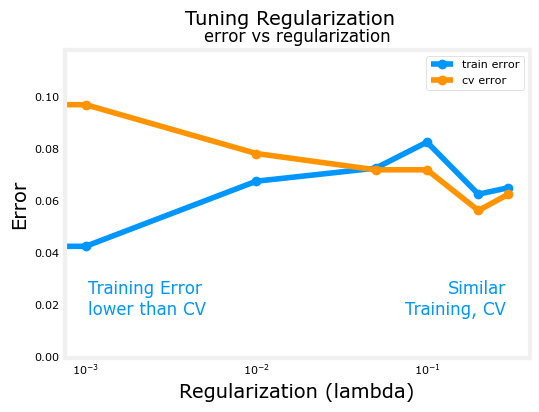

In [47]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

3/3 [==============================] - 0s 1ms/step


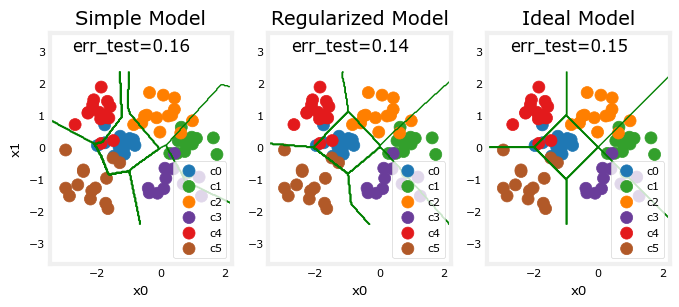

In [48]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)